# Religion

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from religion revisions and religion items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/religion_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/religion.csv')

In [3]:
print("Number of Revisions in Religion Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Religion Dataset")
print(items.shape)

Number of Revisions in Religion Dataset
(32969, 12)
Number of Wikidata Items in Religion Dataset
(13208, 3)


# Data Cleaning

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(32969, 9)

In [8]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [10]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [11]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [12]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [13]:
editscount = rev['qid'].value_counts()

In [14]:
editscount.describe()

count    13158.000000
mean         2.491412
std          3.256492
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        126.000000
Name: qid, dtype: float64

In [15]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [16]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
6102
Items with No of Edits = 2
3315
Items with No of Edits = 3
1191
Items with No of Edits = 4
1424
Items with No of Edits = 5
317
Items with No of Edits <= 5
12349


In [17]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [18]:
df_editscount.shape

(809, 2)

In [19]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [20]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [21]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [22]:
# Discovered wikipedia and wikidata and a template
print(df_editscount.head())
print(rev[rev['qid'] == 'Q4115189'])
print(rev[rev['qid'] == 'Q52'])
print(rev[rev['qid'] == 'Q2013'])

         qid  editscount
0        Q52         126
1      Q2013          91
2  Q17517429          68
3    Q365138          54
4  Q27611973          45
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
     Unnamed: 0  qid   revisionid           timestamp  \
335         961  Q52  383444623.0 2016-10-03 09:03:58   
336         962  Q52     119769.0 2016-10-03 10:06:16   
337         963  Q52  385170099.0 2016-10-08 22:55:55   
338         964  Q52    1404539.0 2016-10-08 23:01:13   
339         965  Q52  385936466.0 2016-10-10 05:44:48   
..          ...  ...          ...                 ...   
456        1083  Q52    2773554.0 2016-12-12 16:53:49   
457        1084  Q52       2496.0 2016-12-12 19:33:12   
458        1085  Q52       4279.0 2016-12-19 21:42:36   
459        1086  Q52  419307423.0 2016-12-23 20:00:22   
460        1087  Q52      46577.0 2016-12-23 21:13:55   

                                  

In [24]:
# Removing wikipedia item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q52'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q52'].index
rev = rev.drop(to_remove_from_rev)

In [25]:
# Removing wikidata item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q2013'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q2013'].index
rev = rev.drop(to_remove_from_rev)

In [26]:
# Removing template item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q17517429'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q17517429'].index
rev = rev.drop(to_remove_from_rev)

In [27]:
print(df_editscount.head())
print(rev[rev['qid'] == 'Q52'])
print(rev[rev['qid'] == 'Q2013'])
print(rev[rev['qid'] == 'Q17517429'])

         qid  editscount
3    Q365138          54
4  Q27611973          45
5  Q27913349          44
6  Q27918436          41
7  Q27670150          39
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []


In [28]:
print("Number of Revisions in Religion Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Religion Dataset after Data Cleaning")
religion_items = rev['qid'].value_counts()
print(religion_items.shape)

Number of Revisions in Religion Dataset after Data Cleaning
(8911, 10)
Number of Wikidata Items in Religion Dataset after Data Cleaning
(806,)


# Descriptive Statistics

In [29]:
print(religion_items.describe().astype(int))

count    806
mean      11
std        6
min        6
25%        7
50%        8
75%       13
max       54
Name: qid, dtype: int32


In [30]:
# Converting a series to a dataframe
r_items = pd.DataFrame({'type':religion_items.index, 'count':religion_items.values})

In [31]:
# Items between the median and 75th percentile
print(r_items[(r_items['count'] >= 8) & (r_items['count'] < 13)])
# Items in the top 25% of the dataset
print(r_items[r_items['count'] >= 13])
# Items below median that is items that fall in the fist 50%
print(r_items[r_items['count'] < 8])
# Items that form the low 25% of the dataset
print(r_items[r_items['count'] < 7])
# Items that are part of 75% of the dataset
print(r_items[r_items['count'] < 13])

          type  count
212     Q34726     12
213  Q21385990     12
214   Q3719285     12
215      Q9585     12
216   Q2868640     12
..         ...    ...
476  Q14397660      8
477    Q224560      8
478    Q810383      8
479  Q15749150      8
480    Q208255      8

[269 rows x 2 columns]
          type  count
0      Q365138     54
1    Q27611973     45
2    Q27913349     44
3    Q27918436     41
4    Q27670150     39
..         ...    ...
207    Q645917     13
208  Q15759430     13
209  Q21441716     13
210  Q15753099     13
211  Q20571352     13

[212 rows x 2 columns]
          type  count
481    Q131036      7
482  Q27725607      7
483   Q2419495      7
484  Q27966918      7
485   Q4783991      7
..         ...    ...
801   Q3595903      6
802  Q27725997      6
803   Q1291627      6
804  Q16620850      6
805   Q3392492      6

[325 rows x 2 columns]
          type  count
618  Q16646335      6
619    Q865115      6
620  Q27640098      6
621    Q478004      6
622    Q718394      6
..  

# Statistics for Proxies

In [32]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [33]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

         count
type          
create    3284
add       3028
update     961
remove     710
set        645
merge      110
revert      85
undo        56
restore     31
protect      1


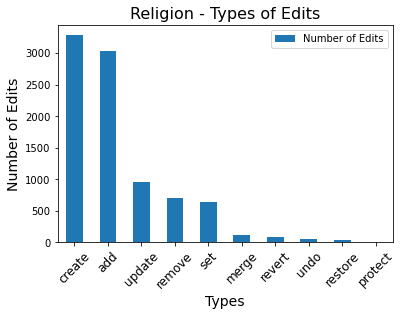

In [34]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Religion - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [35]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

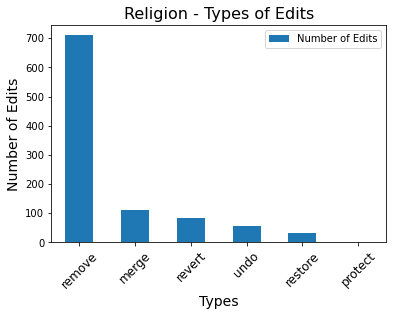

In [36]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Religion - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [37]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
merge      110
revert      85
undo        56
restore     31
protect      1


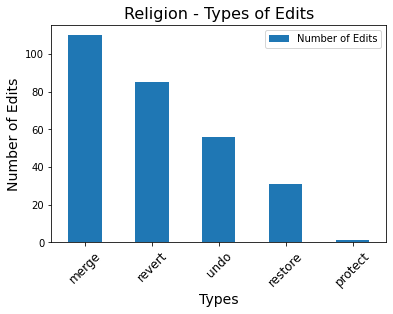

In [38]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Religion - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [40]:
no_of_edits = religion_items.to_numpy()

(array([188.,   0., 137.,   0.,  83.,   0.,  71.,   0.,  49.,   0.,  40.,
          0.,  26.,   0.,  19.,   0.,  13.,   0.,  12.,   0.,  11.,   0.,
         11.,   0.,   0.,   8.,   0.,  19.,   0.,  30.,   0.,  28.,   0.,
         17.,   0.,  12.,   0.,   8.,   0.,   3.,   0.,   4.,   0.,   1.,
          0.,   1.,   0.,   3.,   0.,   0.,   1.,   0.,   2.,   0.,   2.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 6.  ,  6.48,  6.96,  7.44,  7.92,  8.4 ,  8.88,  9.36,  9.84,
        10.32, 10.8 , 11.28, 11.76, 12.24, 12.72, 13.2 , 13.68, 14.16,
        14.64, 15.12, 15.6 , 16.08, 16.56, 17.04, 17.52, 18.  , 18.48,
        18.96, 19.44, 19.92, 20.4 , 20.88, 21.36, 21.84, 22.32, 22.8 ,
        23.28, 23.76, 24.24, 24.72

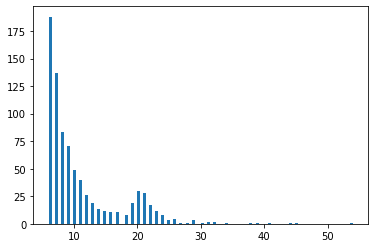

In [41]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

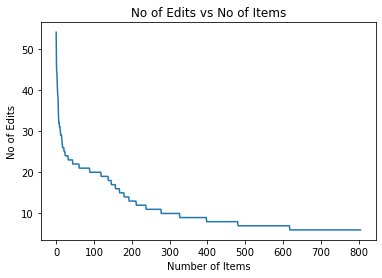

In [42]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [43]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [44]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [45]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [46]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [47]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [48]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [49]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [50]:
proxies = proxies.reset_index()

In [51]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [52]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [53]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [54]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [55]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [56]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,0.105459,0.136476,0.069479,0.038462,0.001241,0.880893,11.055831,3.031017
std,0.488420,0.449966,0.379783,0.222375,0.035223,2.164240,6.413349,2.314476
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,4.000000
max,6.000000,4.000000,5.000000,3.000000,1.000000,37.000000,54.000000,20.000000


Text(0, 0.5, 'No of Edits')

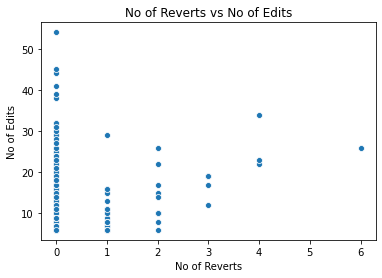

In [57]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

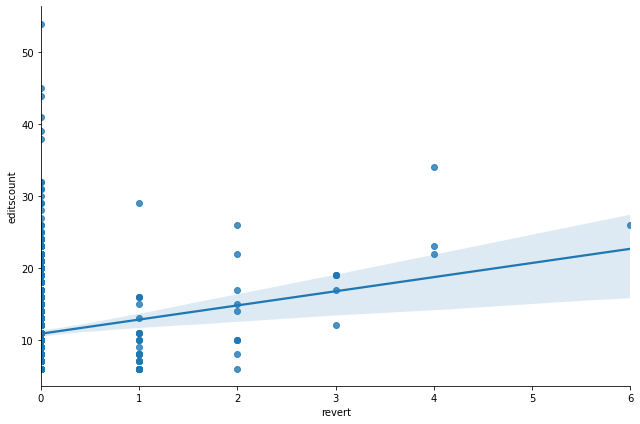

In [58]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [59]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.003394,0.328781,0.317166,0.209006,0.148219,0.150006,0.427871
merge,-0.003394,1.000000,0.046213,0.183357,-0.010697,0.104730,-0.011253,0.066306
undo,0.328781,0.046213,1.000000,0.130118,0.086410,0.069023,0.155490,0.294326
restore,0.317166,0.183357,0.130118,1.000000,0.311088,0.105033,0.131760,0.173872
protect,0.209006,-0.010697,0.086410,0.311088,1.000000,0.001941,0.043685,0.106191
remove,0.148219,0.104730,0.069023,0.105033,0.001941,1.000000,0.236844,0.011402
editscount,0.150006,-0.011253,0.155490,0.131760,0.043685,0.236844,1.000000,0.076375
userscount,0.427871,0.066306,0.294326,0.173872,0.106191,0.011402,0.076375,1.000000


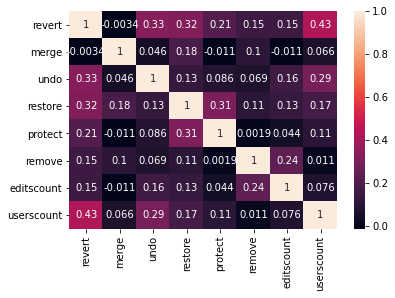

In [60]:
sns.heatmap(corr_matrix, annot=True)

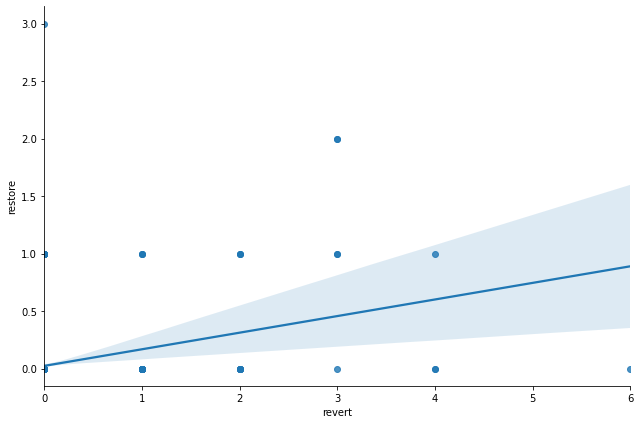

In [61]:
# restore and revert have positive correlation
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

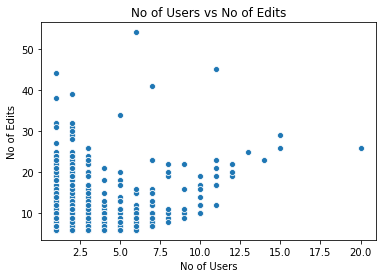

In [62]:
# userscount and editscount have negative correlation 
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

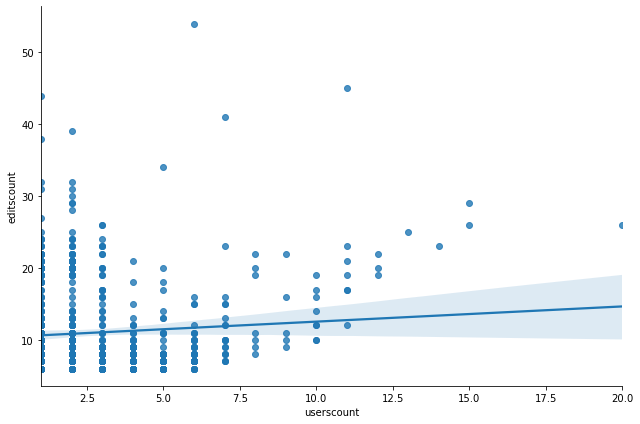

In [63]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=1.5)

In [64]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [65]:
proxies.shape

(347, 9)

In [66]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
3,Q2377326,0,0,0,0,0,1,7,6
9,Q2503193,0,0,0,0,0,1,6,3
10,Q2503488,0,0,0,0,0,37,38,1
12,Q2577588,0,0,0,0,0,2,10,6
14,Q2615878,0,0,0,0,0,14,20,5
...,...,...,...,...,...,...,...,...,...
791,Q28053842,0,0,0,0,0,1,21,1
794,Q28056824,0,0,0,0,0,1,20,1
801,Q28064887,0,0,0,0,0,1,9,3
802,Q28065753,0,0,0,0,0,1,19,2


In [68]:
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [69]:
proxies_without_remove.shape

(155, 9)

In [70]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.397082,0.195719,0.191000,0.197948,0.177631,0.251685,0.537929
merge,-0.397082,1.000000,-0.257802,-0.050871,-0.071221,0.021342,-0.106365,-0.269124
undo,0.195719,-0.257802,1.000000,-0.003394,0.064153,0.023507,0.261507,0.318646
restore,0.191000,-0.050871,-0.003394,1.000000,0.306118,0.107146,0.215711,0.113206
protect,0.197948,-0.071221,0.064153,0.306118,1.000000,-0.018558,0.071651,0.139498
remove,0.177631,0.021342,0.023507,0.107146,-0.018558,1.000000,0.348136,-0.019190
editscount,0.251685,-0.106365,0.261507,0.215711,0.071651,0.348136,1.000000,0.339973
userscount,0.537929,-0.269124,0.318646,0.113206,0.139498,-0.019190,0.339973,1.000000


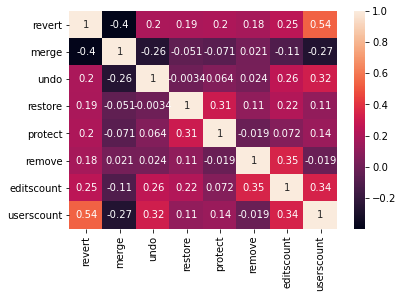

In [71]:
sns.heatmap(corr, annot=True)

# Top 20

## Top 20 Reverts

In [72]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [73]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
42,Q9268,6,0,1,0,0,0,26,15
105,Q483654,4,0,3,1,0,3,22,12
472,Q200180,4,0,0,0,0,18,34,5
476,Q206855,4,0,1,0,0,4,23,11
32,Q1841,3,1,3,0,0,0,19,11
39,Q8449,3,0,3,1,0,1,19,8
48,Q10920,3,0,1,1,0,0,12,7
63,Q35269,3,0,1,2,0,2,17,10
72,Q48183,3,0,1,2,1,1,19,10
28,Q373,2,0,0,0,0,0,10,7


In [75]:
revert_item_labels = ['Judaism', 'Sunni Islam', 'Vietnamese Wikipedia', 'Russian Wikipedia', 'Catholicism',
                     'Spanish Wikipedia', 'Anonymous', 'Jehovah\'s Witnesses', 'German Wikipedia', 'Wikivoyage', 
                     'Islam', 'Christianity', 'atheism', 'Dutch Wikipedia', 'Baháʼí Faith', 
                     'Portada', 'Harry Potter', 'High Renaissance', 'female education', 'Galician-Portuguese lyric']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [76]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
42,Q9268,Judaism,6,0,1,0,0,0,26,15
105,Q483654,Sunni Islam,4,0,3,1,0,3,22,12
472,Q200180,Vietnamese Wikipedia,4,0,0,0,0,18,34,5
476,Q206855,Russian Wikipedia,4,0,1,0,0,4,23,11
32,Q1841,Catholicism,3,1,3,0,0,0,19,11
39,Q8449,Spanish Wikipedia,3,0,3,1,0,1,19,8
48,Q10920,Anonymous,3,0,1,1,0,0,12,7
63,Q35269,Jehovah's Witnesses,3,0,1,2,0,2,17,10
72,Q48183,German Wikipedia,3,0,1,2,1,1,19,10
28,Q373,Wikivoyage,2,0,0,0,0,0,10,7


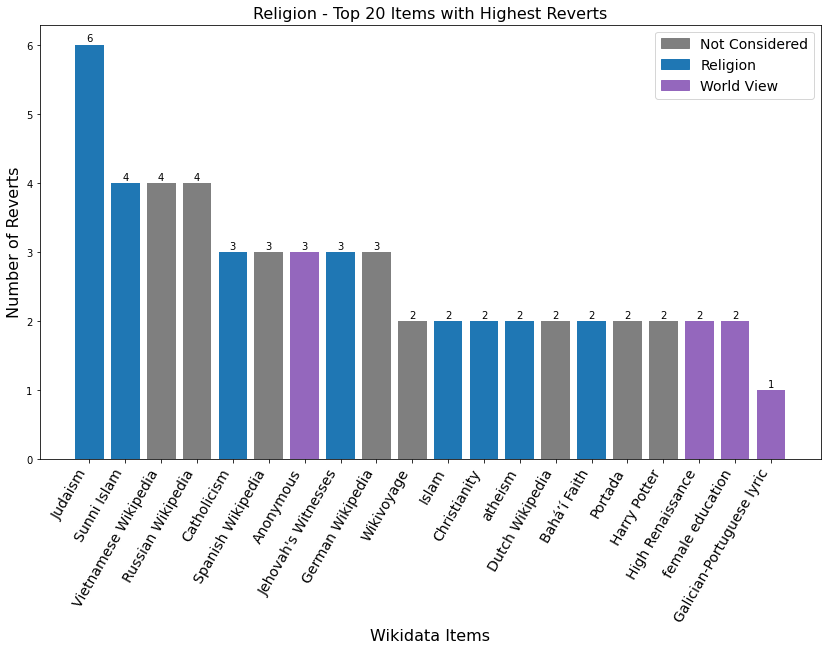

In [77]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:blue', 'tab:blue', 'tab:gray', 'tab:gray', 'tab:blue',
           'tab:gray', 'tab:purple', 'tab:blue', 'tab:gray', 'tab:gray',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:gray', 'tab:blue',
           'tab:gray', 'tab:gray', 'tab:purple', 'tab:purple', 'tab:purple']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
religion = mpatches.Patch(color='tab:blue', label='Religion')
world_view = mpatches.Patch(color='tab:purple', label='World View')

plt.legend(handles=[not_considered, religion, world_view], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Religion - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [78]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [79]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
312,Q13202722,0,4,0,0,0,0,10,4
628,Q20571352,0,4,0,1,0,2,13,5
389,Q25945398,0,3,0,0,0,0,6,3
627,Q20571325,0,3,0,0,0,2,9,4
258,Q7114536,0,2,0,0,0,0,20,8
275,Q8096310,0,2,0,0,0,3,17,3
276,Q8138689,0,2,0,0,0,3,9,3
288,Q9742678,0,2,0,1,0,0,10,4
309,Q13179133,0,2,0,0,0,2,7,3
314,Q13202801,0,2,0,0,0,2,7,2


In [80]:
merge_item_labels = ['permanent duplicate item-France', 'permanent duplicate item-Turkey', 'template-Internet Movie Database', 'permanent duplicate item-USA', 'template1',
                     'religious ecstasy', 'permanent duplicate item-Pyotr Ilyich Tchaikovsky', 'wikimedia-category', 'permanent duplicate item-Austria', 'permanent duplicate item-Soviet Union', 
                     'permanent duplicate item', 'permanent duplicate item-Latvia', 'Portada', 'template2', 'template3', 
                     'Wikinews article', 'permanent duplicate item-music', 'permanent duplicate item-Switzerland', 'permanent duplicate item-silver', 'permanent duplicate item-French']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [81]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
312,Q13202722,permanent duplicate item-France,0,4,0,0,0,0,10,4
628,Q20571352,permanent duplicate item-Turkey,0,4,0,1,0,2,13,5
389,Q25945398,template-Internet Movie Database,0,3,0,0,0,0,6,3
627,Q20571325,permanent duplicate item-USA,0,3,0,0,0,2,9,4
258,Q7114536,template1,0,2,0,0,0,0,20,8
275,Q8096310,religious ecstasy,0,2,0,0,0,3,17,3
276,Q8138689,permanent duplicate item-Pyotr Ilyich Tchaikovsky,0,2,0,0,0,3,9,3
288,Q9742678,wikimedia-category,0,2,0,1,0,0,10,4
309,Q13179133,permanent duplicate item-Austria,0,2,0,0,0,2,7,3
314,Q13202801,permanent duplicate item-Soviet Union,0,2,0,0,0,2,7,2


Text(0.5, 1.0, 'Religion - Top 20 Items with Highest Merges')

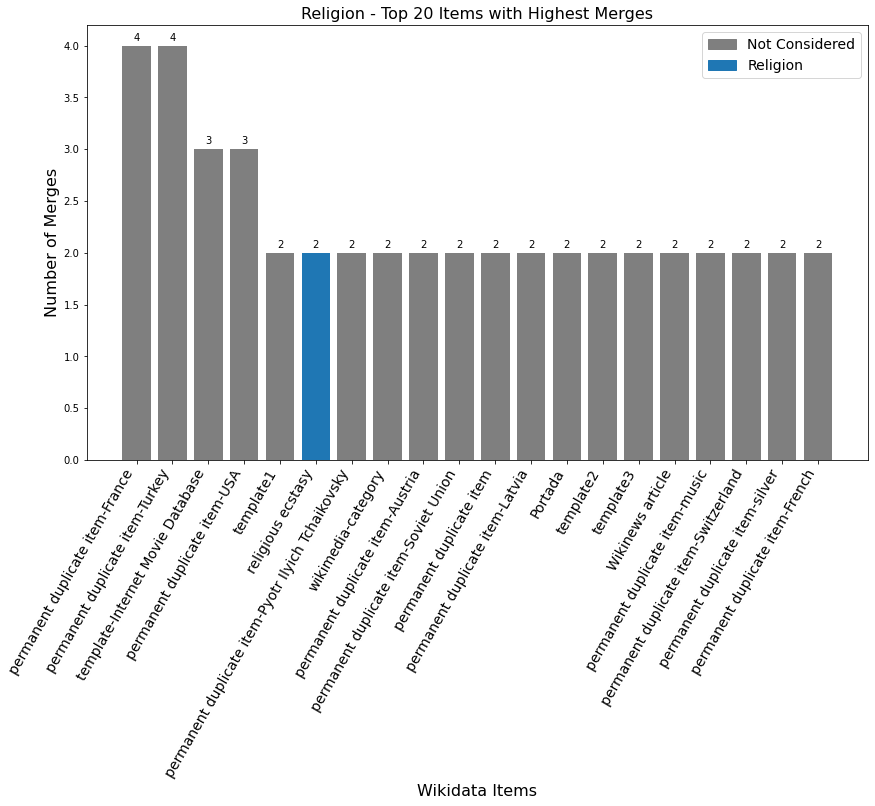

In [82]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:blue', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
religion = mpatches.Patch(color='tab:blue', label='Religion')

plt.legend(handles=[not_considered, religion], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Religion - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [83]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [84]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
494,Q365138,0,1,5,0,0,9,54,6
56,Q23540,0,0,4,0,0,0,17,11
32,Q1841,3,1,3,0,0,0,19,11
39,Q8449,3,0,3,1,0,1,19,8
105,Q483654,4,0,3,1,0,3,22,12
45,Q9585,0,0,2,0,0,1,12,11
69,Q42934,1,0,2,0,0,2,15,7
87,Q93191,0,0,2,0,0,0,11,6
443,Q3057453,0,0,2,0,0,2,8,1
473,Q202472,0,0,2,0,0,0,10,7


In [85]:
undo_item_labels = ['Ngor', 'Protestantism', 'Catholicism', 'Spanish Wikipedia', 'Sunni Islam',
                     'Shia Islam', 'Cubism', 'Baptists', 'no label', 'Lithuanian Wikipedia', 
                     'languages of Azerbaijan', 'provincialism', 'Judaism', 'Anonymous', 'Greek mythology', 
                     'Jehovah\'s Witnesses', 'Hamas', 'German Wikipedia', 'African Americans', 'objectivism']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [86]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
494,Q365138,Ngor,0,1,5,0,0,9,54,6
56,Q23540,Protestantism,0,0,4,0,0,0,17,11
32,Q1841,Catholicism,3,1,3,0,0,0,19,11
39,Q8449,Spanish Wikipedia,3,0,3,1,0,1,19,8
105,Q483654,Sunni Islam,4,0,3,1,0,3,22,12
45,Q9585,Shia Islam,0,0,2,0,0,1,12,11
69,Q42934,Cubism,1,0,2,0,0,2,15,7
87,Q93191,Baptists,0,0,2,0,0,0,11,6
443,Q3057453,no label,0,0,2,0,0,2,8,1
473,Q202472,Lithuanian Wikipedia,0,0,2,0,0,0,10,7


Text(0.5, 1.0, 'Religion - Top 20 Items with Highest Undos')

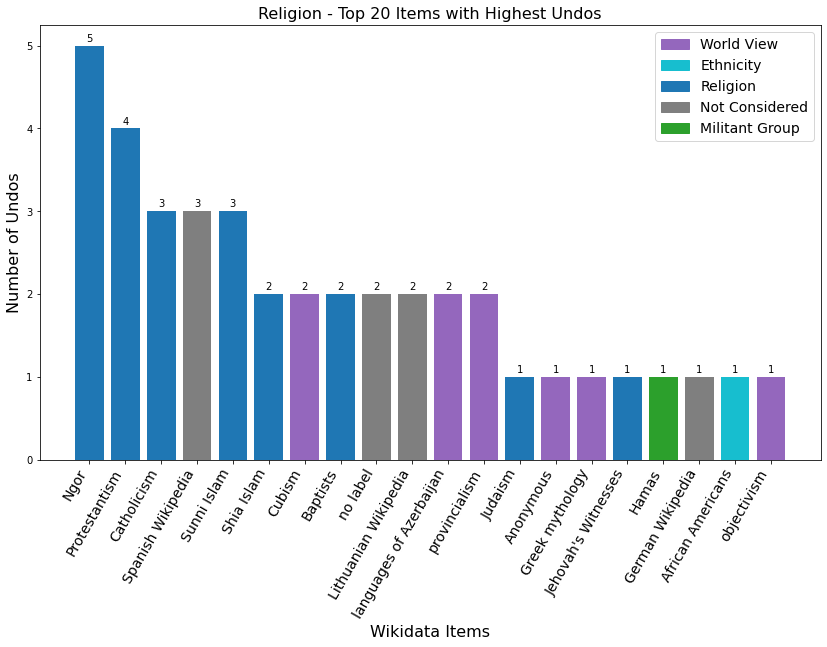

In [87]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:gray', 'tab:blue',
           'tab:blue', 'tab:purple', 'tab:blue', 'tab:gray', 'tab:gray',
           'tab:purple', 'tab:purple', 'tab:blue', 'tab:purple', 'tab:purple',
           'tab:blue', 'tab:green', 'tab:gray', 'tab:cyan', 'tab:purple']

world_view = mpatches.Patch(color='tab:purple', label='World View')
ethnicity = mpatches.Patch(color='tab:cyan', label='Ethnicity')
religion = mpatches.Patch(color='tab:blue', label='Religion')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
militant_group = mpatches.Patch(color='tab:green', label='Militant Group')

plt.legend(handles=[world_view, ethnicity, religion, not_considered, militant_group], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Religion - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [88]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [89]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
310,Q13202698,0,1,0,3,0,0,10,2
63,Q35269,3,0,1,2,0,2,17,10
72,Q48183,3,0,1,2,1,1,19,10
29,Q432,2,0,0,1,0,2,26,20
39,Q8449,3,0,3,1,0,1,19,8
40,Q9089,1,0,0,1,0,1,16,9
47,Q10000,2,0,0,1,0,4,10,4
48,Q10920,3,0,1,1,0,0,12,7
73,Q48204,0,1,0,1,0,3,11,5
105,Q483654,4,0,3,1,0,3,22,12


In [90]:
restore_item_labels = ['no label', 'Jehovah\'s Witnesses', 'German Wikipedia', 'Islam', 'Spanish Wikipedia',
                     'Hinduism', 'Dutch Wikipedia', 'Anonymous', 'voluntary association', 'Sunni Islam', 
                     'rail transport in Angola', 'International Pentecostal Holiness Church', 'wikimedia category', 'duplicated page', 'Portada', 
                     'Cantonese Wikimedia', 'template', 'Wikinews Article', 'Wikimedia List Article', 'academic art']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [91]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
310,Q13202698,no label,0,1,0,3,0,0,10,2
63,Q35269,Jehovah's Witnesses,3,0,1,2,0,2,17,10
72,Q48183,German Wikipedia,3,0,1,2,1,1,19,10
29,Q432,Islam,2,0,0,1,0,2,26,20
39,Q8449,Spanish Wikipedia,3,0,3,1,0,1,19,8
40,Q9089,Hinduism,1,0,0,1,0,1,16,9
47,Q10000,Dutch Wikipedia,2,0,0,1,0,4,10,4
48,Q10920,Anonymous,3,0,1,1,0,0,12,7
73,Q48204,voluntary association,0,1,0,1,0,3,11,5
105,Q483654,Sunni Islam,4,0,3,1,0,3,22,12


Text(0.5, 1.0, 'Religion - Top 20 Items with Highest Restores')

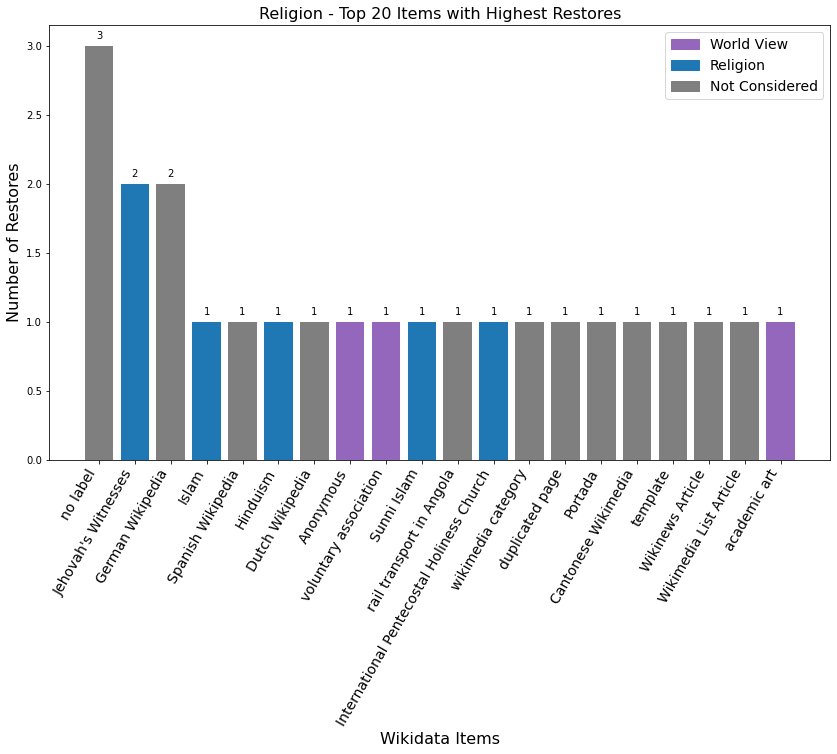

In [92]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

    
colours = ['tab:gray', 'tab:blue', 'tab:gray', 'tab:blue', 'tab:gray',
           'tab:blue', 'tab:gray', 'tab:purple', 'tab:purple', 'tab:blue',
           'tab:gray', 'tab:blue', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:purple']

world_view = mpatches.Patch(color='tab:purple', label='World View')
religion = mpatches.Patch(color='tab:blue', label='Religion')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[world_view, religion, not_considered], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Religion - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [93]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [94]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
494,Q365138,0,1,5,0,0,9,54,6
408,Q27913349,0,0,0,1,0,0,44,1
409,Q27918436,0,1,0,0,0,2,41,7
722,Q27670150,0,0,0,1,0,0,39,2
472,Q200180,4,0,0,0,0,18,34,5
292,Q10360184,0,1,0,0,0,2,32,2
388,Q25945349,0,1,0,0,0,0,32,1
31,Q748,1,0,0,0,0,0,29,15
693,Q27335646,0,0,0,1,0,5,29,2
29,Q432,2,0,0,1,0,2,26,20


In [95]:
edit_item_labels = ['Ngor', 'wikinews article1', 'Wikimedia article-deaths 2016', 'wikinews article2', 'Vietnamese Wikipedia',
                     'Revista de Economia Politica', 'template1', 'Buddhism', 'wikinews article3', 'Islam', 
                     'Judaism', 'Wikimedia list article1', 'Russian Wikipedia', 'Espacio-Jounal', 'Wikimedia article-deaths 2017',  
                     'Sunni Islam', 'Harry Potter', 'Wikimedia list article2', 'template', 'list of presidents of Nauru']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [96]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
494,Q365138,Ngor,0,1,5,0,0,9,54,6
408,Q27913349,wikinews article1,0,0,0,1,0,0,44,1
409,Q27918436,Wikimedia article-deaths 2016,0,1,0,0,0,2,41,7
722,Q27670150,wikinews article2,0,0,0,1,0,0,39,2
472,Q200180,Vietnamese Wikipedia,4,0,0,0,0,18,34,5
292,Q10360184,Revista de Economia Politica,0,1,0,0,0,2,32,2
388,Q25945349,template1,0,1,0,0,0,0,32,1
31,Q748,Buddhism,1,0,0,0,0,0,29,15
693,Q27335646,wikinews article3,0,0,0,1,0,5,29,2
29,Q432,Islam,2,0,0,1,0,2,26,20


Text(0.5, 1.0, 'Religion - Top 20 Items with Highest Edits')

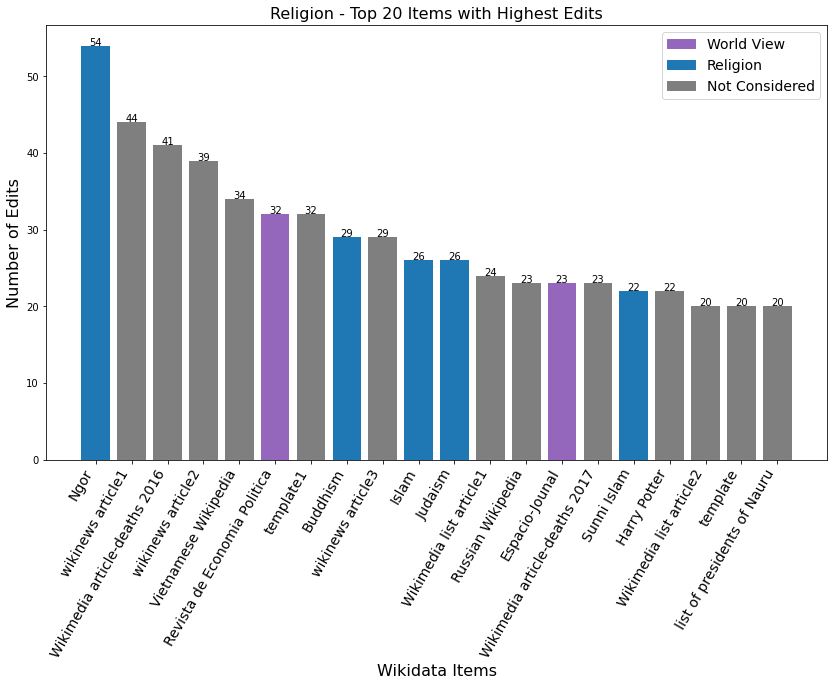

In [97]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')


colours = ['tab:blue', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:purple', 'tab:gray', 'tab:blue', 'tab:gray', 'tab:blue',
           'tab:blue', 'tab:gray', 'tab:gray', 'tab:purple', 'tab:gray',
           'tab:blue', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']

world_view = mpatches.Patch(color='tab:purple', label='World View')
religion = mpatches.Patch(color='tab:blue', label='Religion')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[world_view, religion, not_considered], fontsize=14)


plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Religion - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [98]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [99]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
29,Q432,2,0,0,1,0,2,26,20
31,Q748,1,0,0,0,0,0,29,15
42,Q9268,6,0,1,0,0,0,26,15
773,Q28025478,0,1,0,0,0,1,23,14
75,Q49085,0,0,1,0,0,4,19,12
105,Q483654,4,0,3,1,0,3,22,12
32,Q1841,3,1,3,0,0,0,19,11
34,Q5043,2,0,0,0,0,2,17,11
45,Q9585,0,0,2,0,0,1,12,11
56,Q23540,0,0,4,0,0,0,17,11


In [100]:
user_item_labels = ['Islam', 'Buddhism', 'Judaism', 'Wikimedia list article-deaths2017', 'African Americans',
                     'Sunni Islam', 'Catholicism', 'Christianity', 'Shia Islam', 'Protestantism', 
                     'Russian Wikipedia', 'Jehovah\'s Witnesses ', 'German Wikipedia', 'Hinduism', 'Harry Potter',  
                     'Spanish Wikipedia', 'Hamas', 'template', 'Black Lives Matter', 'Wikivoyage']

# Inserting item labels into user proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [101]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
29,Q432,Islam,2,0,0,1,0,2,26,20
31,Q748,Buddhism,1,0,0,0,0,0,29,15
42,Q9268,Judaism,6,0,1,0,0,0,26,15
773,Q28025478,Wikimedia list article-deaths2017,0,1,0,0,0,1,23,14
75,Q49085,African Americans,0,0,1,0,0,4,19,12
105,Q483654,Sunni Islam,4,0,3,1,0,3,22,12
32,Q1841,Catholicism,3,1,3,0,0,0,19,11
34,Q5043,Christianity,2,0,0,0,0,2,17,11
45,Q9585,Shia Islam,0,0,2,0,0,1,12,11
56,Q23540,Protestantism,0,0,4,0,0,0,17,11


Text(0.5, 1.0, 'Religion - Top 20 Items with Highest Users')

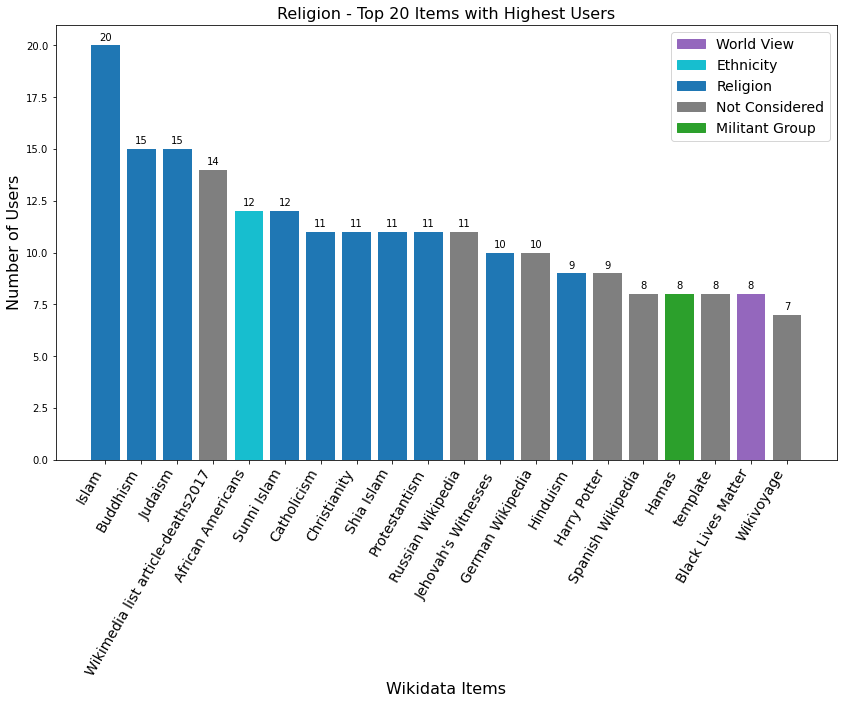

In [108]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.25, str(r), horizontalalignment='center')


colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:gray', 'tab:cyan',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:gray', 'tab:blue', 'tab:gray', 'tab:blue', 'tab:gray',
           'tab:gray', 'tab:green', 'tab:gray', 'tab:purple', 'tab:gray']

world_view = mpatches.Patch(color='tab:purple', label='World View')
ethnicity = mpatches.Patch(color='tab:cyan', label='Ethnicity')
religion = mpatches.Patch(color='tab:blue', label='Religion')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
militant_group = mpatches.Patch(color='tab:green', label='Militant Group')

plt.legend(handles=[world_view, ethnicity, religion, not_considered, militant_group], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Religion - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

In [105]:
# Finding most commonly occurring items in proxies revert, merge, restore and undo
data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)

In [106]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print("Items and the number of times they occurred in top 20 reverts, merges, restores and undos")
print(common_20)

Items and the number of times they occurred in top 20 reverts, merges, restores and undos
Q483654      5
Q9268        4
Q432         4
Q48183       4
Q35269       4
Q8449        4
Q3244512     3
Q10920       3
Q1841        3
Q21446596    3
Q206855      3
Q7114536     3
Q28025478    2
Q373         2
Q365138      2
Q10000       2
Q9742678     2
Q49085       2
Q27913349    2
Q748         2
Name: qid, dtype: int64


Based on the above information and using assumption-3 that items with a diverse range of proxies would be interesting to look at, the following items were selecetd.

- Sunni Islam Q483654
- Jehovah\'s Witnesses Q35269
- Judaism Q9268
- Islam Q432
- Anonymous Q10920

In [107]:
# Storing the revisions of the selected items in CSV files
# rev[rev['qid'] == 'Q483654'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/religion/SunniIslam_QQ483654.csv')
# rev[rev['qid'] == 'Q35269'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/religion/Jehovah_Q35269.csv')
# rev[rev['qid'] == 'Q9268'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/religion/Judaism_Q9268.csv')
# rev[rev['qid'] == 'Q432'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/religion/Islam_Q432.csv')
# rev[rev['qid'] == 'Q10920'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/religion/Anonymous_Q10920.csv')